# AGNQSO Summary catalogue generator

See:
'\*\*\*TO_DO\*\*\*'
'\*\*\*TO_FINISH\*\*\*'
in text

All functions and final wrapper script to live in .py but this is notebook showing the process

Notebook by:

* Alexander, D (Univ. of Durham, Durham, UK) (VI merging done by DA)
* Alfarsy, R (Univ. of Portsmouth, Portsmouth, UK)
* Canning, B (Univ. of Portsmouth, Portsmouth, UK)
* Chaussidon, E (CEA Saclay, Paris, France) (QSO catalogs generated by EC et al.)
* Juneau, S (NOIRLab, Arizona, USA)
* Mezcua, M (Institut de Ciències de l'Espai, Barcelona, Spain)
* Moustakas, J (Siena College, New York, USA) (FastSpecFit catalogues by JM)
* Pucha, R (Univ. of Arizona, Arizona, USA) 

## Docs:
(Will make a read the doc for github)
Github:

## Imports

In [40]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os.path
import yaml

# Import Astropy libraries - useful for many astronomy related function
from astropy.table import Table, join
from astropy.io import fits
import fitsio

# DESI modules
from desispec.zcatalog import find_primary_spectra, create_summary_catalog  # at NERSC needs DESI master
from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask      # For the main survey
from desiutil.bitmask import BitMask

# GQP_CODE
from set_agn_masks import create_bpt_mask_all, test_bpt_mask


In [41]:
## Making the matplotlib plots look nicer - from SJ
settings = {
    'font.size':16,
    'axes.linewidth':2.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':2.0,
    'xtick.minor.width':1.,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':2.0,
    'ytick.minor.width':1.,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

# Workflow

Directory is: /global/u2/b/bcanning/AGNQSO_summary_catalog
Temporary files in: /global/u2/b/bcanning/AGNQSO_summary_catalog/tmp

1. Parent catalogue from QSO Maker all targets (see EC et al.)
2. Join to parent zpix summary catalogue to include the 'primary' flag (see SJ, RP)
3. Read yaml (see BC, RP)
4. QSO/BGS/LRG/ELG cuts applied (see DA et al.)
5. FastSpecFit joined (see JM)
6. Multiwavelength Cats joined (see RA)
7. Make AGNType diagnostics joining reading yaml (see RP, MM, SJ, BC)
6. Catalogue output

## Basic Info (edit for choosing data release)

In [42]:
dir_for_cat='/global/u2/b/bcanning/AGNQSO_summary_catalog/'
dir_for_tmp='/global/u2/b/bcanning/AGNQSO_summary_catalog/tmp/'

filetype = 'healpix'
specgroup_type = 'zpix'

# Which spectroscopic release
specprod = 'fuji'
#specprod = 'guadalupe'
#specprod = 'all' # this is to wrap fuji and guadalupe ***TO_DO***

#### OTHER FILES NEEDED 
# Edmonds catalogue from QSO maker keeping all columns
# filename for all targets (keeping everything with a QSO_MASKBITS column for default classification)
# ***TO_FINISH*** datalab version needs writing
#path_qsom = f'{specprod}/'  #Data Lab with local copy 
path_qsom = f'/global/cfs/cdirs/desi/users/edmondc/QSO_catalog/{specprod}/'  #NERSC
file_qsom = path_qsom+f'QSO_cat_{specprod}_healpix_all_targets.fits'

# FastSpecFit file - in development
# ***TO_FINISH*** naming will change
fast_dir = f'/global/cfs/cdirs/desi/spectro/fastspecfit/fujidev/f1' #/catalogs' # NERSC  
fastspec_file = f'{fast_dir}/fastspec-f1.fits'

# VI files
#vipath = '/global/cfs/cdirs/desi/sv/vi/TruthTables/'  # NERSC
#vipath = 'VI_results/' # Data Lab
#vifile = vipath+'desi-vi_BGS_AGN_sv3_merged_220423.csv'   #added SURVEY+PROGRAM



In [43]:
# Main identifiers for Joins
keys_for_join=['TARGETID','SURVEY','PROGRAM']

## 1. QSO-maker Cat

In [44]:
%%time
## Read fits file into an Astropy table (takes ~20sec)
T_qsom = Table(fitsio.read(file_qsom)) 
##CPU times: user 19.9 s, sys: 5.36 s, total: 25.2 s
##Wall time: 25.3 s
## Read fits file into an Astropy table (takes ~2sec) BUT need to convert quick recarry into Table for join and 
## Table take ages!
#hdul = fits.open(file)
#cols_qsom = hdul[1].columns
#T_qsom = hdul[1].data
##CPU times: user 1.41 s, sys: 452 ms, total: 1.86 s
##Wall time: 1.86 s
#cols_qsom.names

CPU times: user 20.2 s, sys: 5.57 s, total: 25.8 s
Wall time: 25.8 s


In [45]:
#%%time
## Takes ~3 sec
#DF_qsom = T_qsom.to_pandas()

## 2. Zpix Summary Cat with primary flag

This function is used to add columns useful for the primary spectra identification

In [46]:
file_zpix_sum_cat=dir_for_tmp+'zpix-'+specprod+'-summary.fits'

In [47]:
# from https://github.com/desihub/desispec/blob/master/py/desispec/zcatalog.py
# for fugi 2Gb file (approx 5 mins)
if os.path.isfile(file_zpix_sum_cat):
    print('zpix summary file exists - using existing copy')
else:
    print('Creating zpix summery file - may take 5 mins')
    create_summary_catalog(specprod, specgroup = specgroup_type, all_columns = True, columns_list = None, output_filename = file_zpix_sum_cat)

zpix summary file exists - using existing copy


In [48]:
##hdul = fits.open(file_zpix_sum_cat)
##cols_zpixsum = hdul[1].columns
##T_zpixsum = hdul[1].data
## Using Table not recarray to join and support multiple column select
T_zpixsum = Table(fitsio.read(file_zpix_sum_cat)) 

In [49]:
need_cols = ['TARGETID','SURVEY','PROGRAM','TSNR2_LRG','SV_NSPEC','SV_PRIMARY','ZCAT_NSPEC','ZCAT_PRIMARY'] # fuji
#need_cols = ['TARGETID','SURVEY','PROGRAM','TSNR2_LRG','ZCAT_NSPEC','ZCAT_PRIMARY'] # guadalupe
T_zpixsum_cut = T_zpixsum[need_cols]
T_qsom_zpixsum = join(T_qsom, T_zpixsum_cut, keys=keys_for_join, join_type='left')

In [50]:
## Adding two columns we need for the cuts
# a=np.array([fuji_t['C_LYA'], fuji_t['C_CIV'], fuji_t['C_CIII'], fuji_t['C_MgII'], fuji_t['C_Hbeta'], fuji_t['C_Halpha']])
# high_value = [max(l) for l in (a.T).tolist()]
# second_high_value = [sorted(l)[-2] for l in (a.T).tolist()]
a = np.array([T_qsom_zpixsum['C_LYA'], T_qsom_zpixsum['C_CIV'], T_qsom_zpixsum['C_CIII'], \
              T_qsom_zpixsum['C_MgII'], T_qsom_zpixsum['C_Hbeta'], T_qsom_zpixsum['C_Halpha']])
T_qsom_zpixsum['QN_C_LINE_BEST'] = [max(l) for l in (a.T).tolist()]
T_qsom_zpixsum['QN_C_LINE_SECOND_BEST'] = [sorted(l)[-2] for l in (a.T).tolist()]
T = T_qsom_zpixsum

## 3. Read Yaml

In [51]:
def get_qso_maskbits(file):
    file_yaml = open(file, 'r')
    yaml_defs = yaml.safe_load(file_yaml)
    QSO_MASKBITS = BitMask('QSO_MASKBITS', yaml_defs)
    AGN_MASKBITS = BitMask('AGN_MASKBITS', yaml_defs)
    AGN_TYPE = BitMask('AGN_TYPE', yaml_defs)
    return QSO_MASKBITS, AGN_MASKBITS, AGN_TYPE

In [52]:
# QSO_MASKBITS, AGN_MASKBITS, AGN_TYPE = get_qso_maskbits(dir_for_cat+'agnmask.yaml')
# ## EC doesn't use yaml - no QN_NEW_RR but we add this
# select_RR = T['QSO_MASKBITS'] & QSO_MASKBITS.RR != 0
# select_mgii = (~select_RR) & (T['QSO_MASKBITS'] & QSO_MASKBITS.MGII != 0)  
# select_QN = ~select_RR & ~select_mgii & (T['QSO_MASKBITS'] & QSO_MASKBITS.QN != 0)

## 4. Make Cuts

In [53]:
# ***TO_DO*** add VI truth tables so can explore these cuts

In [54]:
#### Fibre status

In [55]:
def cut_fiberstatus(T):
    ''' 
    keep only objects with 'COADD_FIBERSTATUS' == 0
    '''
    keep = (T['COADD_FIBERSTATUS']==0)
    return T[keep]

#### QSO targets
```
(QN_C_LINE_BEST > 0.95)|(DELTA_CHI2_MGII>16)
```

In [56]:
def is_qso_qso(T):
    '''
    
    (QN_C_LINE_BEST > 0.95)|(DELTA_CHI2_MGII>16)
    
    T['QSO_MASKBITS']>0 should be this cut ***but it is not***
    
    BC TO DO - check on 0.95, mgii
    
    '''
    from desitarget.targetmask import desi_mask 
    QSO_MASKBITS, AGN_MASKBITS, AGN_TYPE = get_qso_maskbits(dir_for_cat+'agnmask.yaml')
    select_RR = T['QSO_MASKBITS'] & QSO_MASKBITS.RR != 0
    select_mgii = (~select_RR) & (T['QSO_MASKBITS'] & QSO_MASKBITS.MGII != 0)  
    select_QN = ~select_RR & ~select_mgii & (T['QSO_MASKBITS'] & QSO_MASKBITS.QN != 0)
    qso_tgtmask = desi_mask['QSO']
    desi_target = T['DESI_TARGET']
    is_qso = (desi_target & qso_tgtmask != 0)|(T['SV1_DESI_TARGET'] & qso_tgtmask != 0)| \
         (T['SV2_DESI_TARGET'] & qso_tgtmask != 0)|(T['SV3_DESI_TARGET'] & qso_tgtmask != 0)
    #is_qso_qso = is_qso&(T['QSO_MASKBITS']>0 )   # use default for QSO targets... need to check
    is_qso_qso = is_qso&((T['QN_C_LINE_BEST']>0.95)|select_mgii)
    print(len(T[is_qso_qso]), 'qsos from QSO targets' )
    return is_qso_qso


In [57]:
is_qso_qso=is_qso_qso(T)

87194 qsos from QSO targets


#### ELG targets
```
((QN_C_LINE_BEST > 0.9999)&(QN_C_LINE_SECOND_BEST>0.95))|(DELTA_CHI2_MGII>16)
```

In [58]:
def is_qso_elg(T):
    '''
    QSOs from ELG targets 
    ((QN_C_LINE_BEST > 0.9999)&(QN_C_LINE_SECOND_BEST>0.95))|(DELTA_CHI2_MGII>16)
    '''
    from desitarget.targetmask import desi_mask 
    QSO_MASKBITS, AGN_MASKBITS, AGN_TYPE = get_qso_maskbits(dir_for_cat+'agnmask.yaml')
    select_RR = T['QSO_MASKBITS'] & QSO_MASKBITS.RR != 0
    select_mgii = (~select_RR) & (T['QSO_MASKBITS'] & QSO_MASKBITS.MGII != 0)  
    select_QN = ~select_RR & ~select_mgii & (T['QSO_MASKBITS'] & QSO_MASKBITS.QN != 0)
    desi_target = T['DESI_TARGET']
    elg_tgtmask = desi_mask['ELG']
    is_elg = (desi_target & elg_tgtmask != 0)|(T['SV1_DESI_TARGET'] & elg_tgtmask != 0)| \
             (T['SV2_DESI_TARGET'] & elg_tgtmask != 0)|(T['SV3_DESI_TARGET'] & elg_tgtmask != 0)
    is_qso_elg = is_elg&(((T['QN_C_LINE_BEST']>0.9999)&(T['QN_C_LINE_SECOND_BEST']>0.95))|select_mgii)
    print(len(T[is_qso_elg]), 'qsos from ELG targets' )
    return is_qso_elg

In [59]:
is_qso_elg=is_qso_elg(T)

39459 qsos from ELG targets


#### LRG targets
```
((QN_C_LINE_BEST > 0.95)&(QN_C_LINE_SECOND_BEST>0.95))|(DELTA_CHI2_MGII>16)
```

In [60]:
def is_qso_lrg(T):
    '''
    QSOs from LRG targets 
    ((QN_C_LINE_BEST > 0.95)&(QN_C_LINE_SECOND_BEST>0.95))|(DELTA_CHI2_MGII>16)
    '''
    from desitarget.targetmask import desi_mask 
    QSO_MASKBITS, AGN_MASKBITS, AGN_TYPE = get_qso_maskbits(dir_for_cat+'agnmask.yaml')
    select_RR = T['QSO_MASKBITS'] & QSO_MASKBITS.RR != 0
    select_mgii = (~select_RR) & (T['QSO_MASKBITS'] & QSO_MASKBITS.MGII != 0)  
    select_QN = ~select_RR & ~select_mgii & (T['QSO_MASKBITS'] & QSO_MASKBITS.QN != 0)
    desi_target = T['DESI_TARGET']
    lrg_tgtmask = desi_mask['LRG']
    is_lrg = (desi_target & lrg_tgtmask != 0)|(T['SV1_DESI_TARGET'] & lrg_tgtmask != 0)| \
             (T['SV2_DESI_TARGET'] & lrg_tgtmask != 0)|(T['SV3_DESI_TARGET'] & lrg_tgtmask != 0)
    is_qso_lrg = is_lrg&(((T['QN_C_LINE_BEST']>0.95)&(T['QN_C_LINE_SECOND_BEST']>0.95))|select_mgii)
    print(len(T[is_qso_lrg]), 'qsos from LRG targets' )
    return is_qso_lrg

In [61]:
is_qso_lrg=is_qso_lrg(T)

6296 qsos from LRG targets


#### BGS
Not sure what this is right now

In [62]:
def is_qso_bgs(T):
    '''
    QSOs from BGS targets 
    
    currently uses BGS_ANY 
    
    ???
    '''
    from desitarget.targetmask import desi_mask 
    QSO_MASKBITS, AGN_MASKBITS, AGN_TYPE = get_qso_maskbits(dir_for_cat+'agnmask.yaml')
    select_RR = T['QSO_MASKBITS'] & QSO_MASKBITS.RR != 0
    select_mgii = (~select_RR) & (T['QSO_MASKBITS'] & QSO_MASKBITS.MGII != 0)  
    select_QN = ~select_RR & ~select_mgii & (T['QSO_MASKBITS'] & QSO_MASKBITS.QN != 0)
    desi_target = T['DESI_TARGET']
    bgs_tgtmask = desi_mask['BGS_ANY']
    is_bgs = (desi_target & bgs_tgtmask != 0)|(T['SV1_DESI_TARGET'] & bgs_tgtmask != 0)| \
             (T['SV2_DESI_TARGET'] & bgs_tgtmask != 0)|(T['SV3_DESI_TARGET'] & bgs_tgtmask != 0)
    is_qso_bgs = is_bgs&(select_RR|select_mgii)
    print(len(T[is_qso_bgs]), 'qsos from BGS targets' )
    return is_qso_bgs

In [63]:
is_qso_bgs=is_qso_bgs(T)

6956 qsos from BGS targets


#### Secondary targets

In [64]:
def is_qso_scnd(T):
    '''
    find the secondary targets
    
    BC TO Do - this is not quite right yet as secondaries 
    could need different cuts too based on secondary program
    
    '''
    from desitarget.targetmask import desi_mask 
    desi_target = T['DESI_TARGET']
    scnd_tgtmask = desi_mask['SCND_ANY']    
    is_scnd = (desi_target & scnd_tgtmask != 0)|(T['SV1_DESI_TARGET'] & scnd_tgtmask != 0)| \
              (T['SV2_DESI_TARGET'] & scnd_tgtmask != 0)|(T['SV3_DESI_TARGET'] & scnd_tgtmask != 0)
    is_qso_scnd = is_scnd&(T['QSO_MASKBITS']>0)
    print(len(T[is_qso_scnd]), 'qsos from SECONDARY targets' )
    return is_qso_scnd

In [65]:
is_qso_scnd=is_qso_scnd(T)

39265 qsos from SECONDARY targets


#### Find sky fibers which are qso

In [66]:
def is_qso_sky(T):
    '''
    find the sky targets
    
    '''
    from desitarget.targetmask import desi_mask 
    desi_target = T['DESI_TARGET']
    sky_tgtmask = desi_mask['SKY']  
    is_sky = (desi_target & sky_tgtmask!= 0)
    is_qso_sky = is_sky&(T['QSO_MASKBITS']>0)
    print(len(T[is_qso_sky]), 'qsos from SKY targets' )
    return is_qso_sky

In [67]:
is_qso_sky=is_qso_sky(T)

14882 qsos from SKY targets


#### Overall classify as QSO if it makes any of the target-type cuts

In [68]:
### This from SJ notesbook but think now different cuts made by EC - will test

# # Problem redshift z>3.7
# sel_pb_redshift_old = (cat['Z'] > 3.65) & ((cat['C_LYA']<0.95) | (cat['C_CIV']<0.95))
# sel_hiz = (cat['Z'] > 3.65) & ((cat['C_LYA']>=0.95) & (cat['C_CIV']>=0.95))

# ## To Do: change above to exclude secondary targets from the cut
# ## Question: change it further to exclude the two peaks *but* need to check the cut at z<=6
# ## (might also need to keep excluding sky fibers in between the redshift overlap "peaks"? -- CHECK)
# sel_pb_redshift = sel_pb_redshift_old & (~is_scnd)
# qso_cuts = (is_qso_qso|is_qso_elg|is_qso_lrg|is_qso_bgs|is_qso_scnd|is_qso_sky)&(~sel_pb_redshift)  ## try ignoring BGS?!

#qso_cuts = (is_qso_qso|is_qso_elg|is_qso_lrg|is_qso_bgs|is_qso_scnd|is_qso_sky)
qso_cuts = (is_qso_qso|is_qso_elg|is_qso_lrg|is_qso_bgs|is_qso_scnd)
print('Number of QSO targets:', len(T[qso_cuts]))

Number of QSO targets: 104624


In [69]:
# write out this catalogue
Tout=T[qso_cuts]
Tout.columns

<TableColumns names=('TARGETID','Z','ZERR','ZWARN','SPECTYPE','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','MORPHTYPE','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_W1','FLUX_IVAR_W2','MASKBITS','DESI_TARGET','SCND_TARGET','COADD_NUMEXP','COADD_EXPTIME','CMX_TARGET','SV1_DESI_TARGET','SV2_DESI_TARGET','SV3_DESI_TARGET','SV1_SCND_TARGET','SV2_SCND_TARGET','SV3_SCND_TARGET','TSNR2_LYA','TSNR2_QSO','DELTA_CHI2_MGII','A_MGII','SIGMA_MGII','B_MGII','VAR_A_MGII','VAR_SIGMA_MGII','VAR_B_MGII','Z_RR','Z_QN','C_LYA','C_CIV','C_CIII','C_MgII','C_Hbeta','C_Halpha','Z_LYA','Z_CIV','Z_CIII','Z_MgII','Z_Hbeta','Z_Halpha','QSO_MASKBITS','HPXPIXEL','SURVEY','PROGRAM','TSNR2_LRG','SV_NSPEC','SV_PRIMARY','ZCAT_NSPEC','ZCAT_PRIMARY','QN_C_LINE_BEST','QN_C_LINE_SECOND_BEST')>

In [70]:
# this was for Alice in May
#Talice=Tout['TARGETID','Z','ZERR','ZWARN','SPECTYPE','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','MORPHTYPE','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_W1','FLUX_IVAR_W2','MASKBITS','DESI_TARGET','SCND_TARGET']

In [71]:
# this was for Alice in May
#hdu = fits.BinTableHDU(data=Talice)
##hdu.writeto('AGNQSO_summary_Fuji_May22_for_Alice.fits')
#hdu.writeto('AGNQSO_summary_Fuji_May22_for_Alice_no_sky.fits')
##hdu.writeto('AGNQSO_summary_Guadalupe_May22_for_Alice_no_sky.fits')
##hdu.writeto('AGNQSO_summary_Guadalupe_May22_for_Alice_no_sky.fits')

In [72]:
#### Make QSO_MASKBITS ***TO_FINISH***
T.columns

<TableColumns names=('TARGETID','Z','ZERR','ZWARN','SPECTYPE','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','MORPHTYPE','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_W1','FLUX_IVAR_W2','MASKBITS','DESI_TARGET','SCND_TARGET','COADD_NUMEXP','COADD_EXPTIME','CMX_TARGET','SV1_DESI_TARGET','SV2_DESI_TARGET','SV3_DESI_TARGET','SV1_SCND_TARGET','SV2_SCND_TARGET','SV3_SCND_TARGET','TSNR2_LYA','TSNR2_QSO','DELTA_CHI2_MGII','A_MGII','SIGMA_MGII','B_MGII','VAR_A_MGII','VAR_SIGMA_MGII','VAR_B_MGII','Z_RR','Z_QN','C_LYA','C_CIV','C_CIII','C_MgII','C_Hbeta','C_Halpha','Z_LYA','Z_CIV','Z_CIII','Z_MgII','Z_Hbeta','Z_Halpha','QSO_MASKBITS','HPXPIXEL','SURVEY','PROGRAM','TSNR2_LRG','SV_NSPEC','SV_PRIMARY','ZCAT_NSPEC','ZCAT_PRIMARY','QN_C_LINE_BEST','QN_C_LINE_SECOND_BEST')>

In [73]:
# for T[select_QN] compare Z and from RR and from QN and if Z changed then set QSO_MASKBITS 4

## 5. Join FastSpecFit

In [74]:
# Read the fastspecfit file
# FSF stores relevent joining info in header not table columns
fsf_all = fits.open(fastspec_file)
fsf_t = Table(fsf_all['FASTSPEC'].data)
fsf_m = Table(fsf_all['METADATA'].data)

In [75]:
# first join the fsf header columns needed to the fsf table
fsf_m_sel = fsf_m[keys_for_join]
# Joining the two fastspec tables to create a single table
fsf = join(fsf_m_sel, fsf_t, keys = 'TARGETID')    
# Left-joining the zcatalog and fastspec table
T_fsf = join(T, fsf, join_type='left', keys=keys_for_join)

## 6. Join multiwave survey

In [76]:
## 7. join multiwave survey ***TO_FINISH*** RA has started this

#### SDSS join

## 7. Make DESI AGN diagnostics

In [38]:
# ***TO_fiNISH*** somethign is overwriting itsself here...
## RP code for indiviudal call to create_bpt_mask
# survey = 'sv3'
# faprgrm = 'bright'
# specred = 'everest'
# # This creates the mask and adds it as a column
# tab = create_bpt_mask(survey = survey, faprgrm = faprgrm, yaml_file='agnmask.yaml', specred = specred)
# ***TO_FINISH*** emline_classification needs a tidyup
QSO_MASKBITS, AGN_MASKBITS, AGN_TYPE = get_qso_maskbits(dir_for_cat+'agnmask.yaml')
T_bpt=create_bpt_mask_all(T_fsf, AGN_TYPE)

Found mask


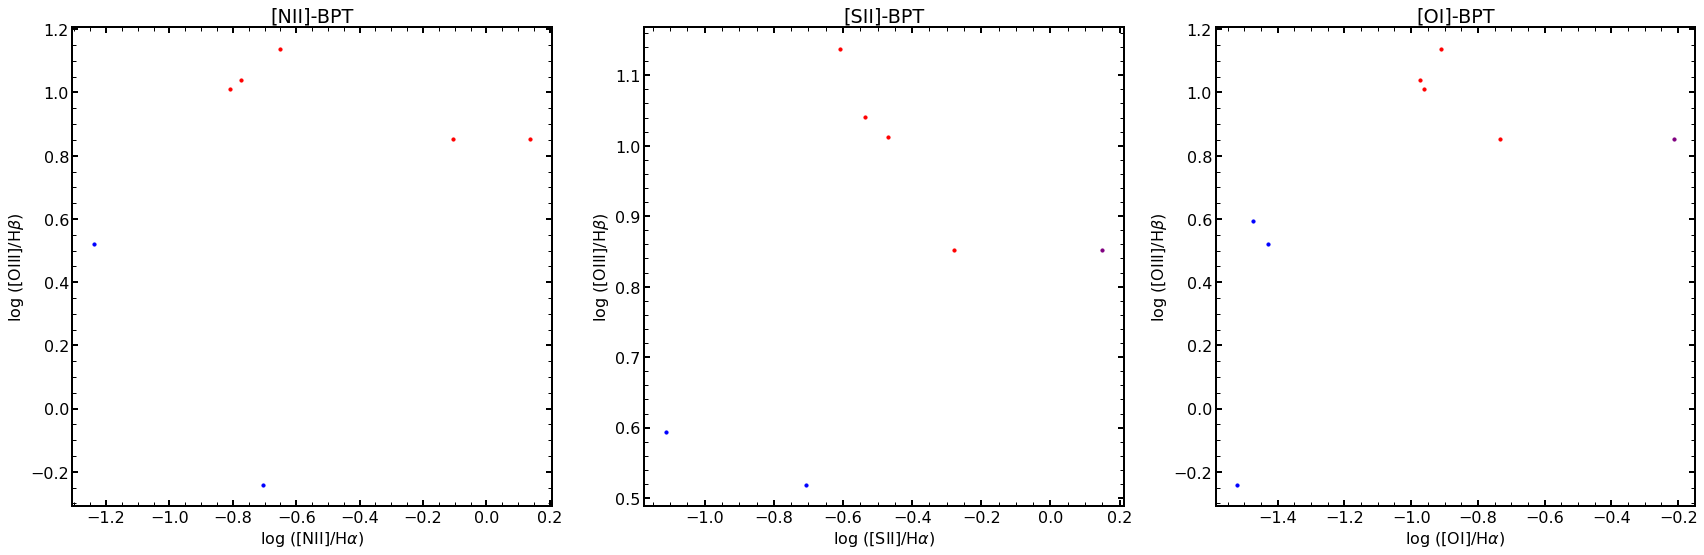

In [39]:
test_bpt_mask(T_bpt, AGN_TYPE, dir_for_tmp)

In [142]:
### cuts added by EC but leaving in here for discussion with SJ

# #### Notes/Questions
# - How to treat objects that might have more than one target type?
# - Correct bump at z~3.7:
# ```
#     sel_pb_redshift = (QSO_cat['Z'] > 3.65) & ((QSO_cat['C_LYA']<0.95) | (QSO_cat['C_CIV']<0.95))
# ```

In [40]:
# below stuff from SJ notebook - leaving in for potntial testing stuff

## Plot redshift distributions - from SJ code 

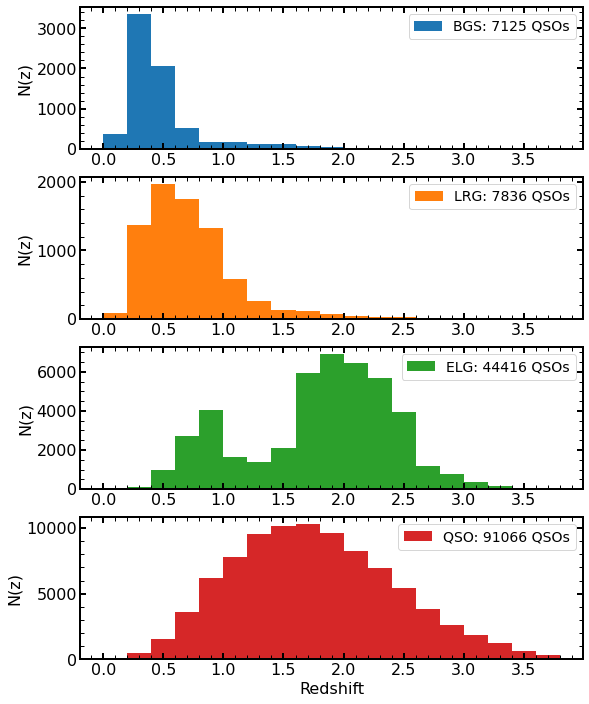

In [85]:
# Now let us look at the distribution of redshifts -

rr = [is_bgs, is_lrg, is_elg, is_qso]
rnames = ['BGS', 'LRG', 'ELG', 'QSO']

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

for i, ax in enumerate(axs.flatten()):
    rq = qso_cuts&rr[i]
    ax.hist(cat['Z'][rq], color = f'C{i}', bins = bins, label = f'{rnames[i]}: {len(cat[rq])} QSOs')
    ax.legend(fontsize = 14)
    ax.set_ylabel("N(z)")
    if i==3: ax.set_xlabel("Redshift")
    

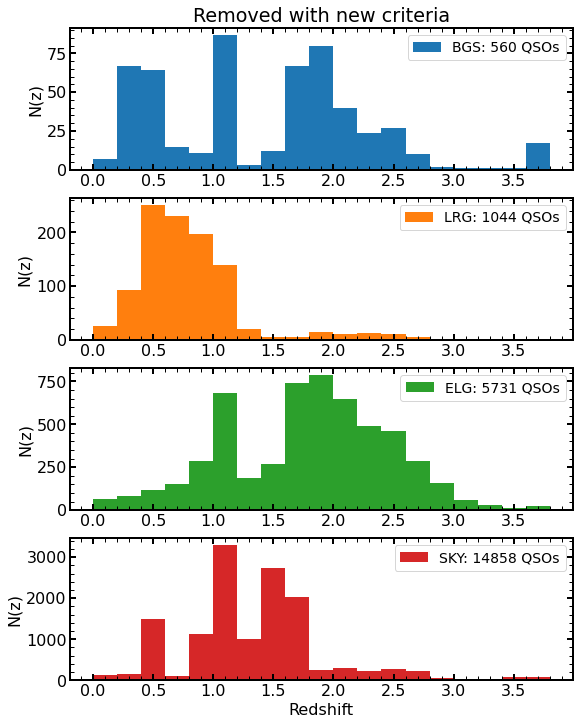

In [86]:
# Distribution of redshifts for the QSO candidates that were REMOVED with the new cuts

rr = [is_bgs, is_lrg, is_elg, is_sky]
rnames = ['BGS', 'LRG', 'ELG', 'SKY']

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

for i, ax in enumerate(axs.flatten()):
    rq = invalid&rr[i]
    ax.hist(cat['Z'][rq], color = f'C{i}', bins = bins, label = f'{rnames[i]}: {len(cat[rq])} QSOs')
    ax.legend(fontsize = 14)
    ax.set_ylabel("N(z)")
    if i==0: ax.set_title("Removed with new criteria")
    if i==3: ax.set_xlabel("Redshift")

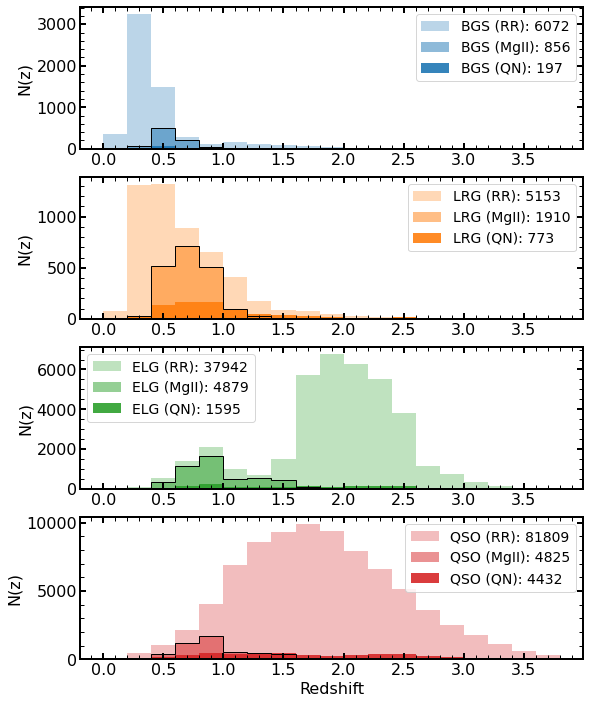

In [87]:
# distribution of redshifts per target type and per QSO selection method

rr = [is_bgs, is_lrg, is_elg, is_qso]
rnames = ['BGS', 'LRG', 'ELG', 'QSO']

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)  #default range from 0 to 4
#bins = np.arange(2.1, 4.1, 0.2)  #high z range 2.1 to 4.1


for i, ax in enumerate(axs.flatten()):
    rq = qso_cuts&rr[i]
    ax.hist(cat['Z'][(rq)&sel_RR], color = f'C{i}', bins = bins, label = f'{rnames[i]} (RR): {len(cat[rq&sel_RR])}',alpha=0.3)
    ax.hist(cat['Z'][(rq)&sel_mgII], color = f'C{i}', bins = bins, label = f'{rnames[i]} (MgII): {len(cat[rq&sel_mgII])}',alpha=0.5)
    ax.hist(cat['Z'][(rq)&sel_QN], color = f'C{i}', bins = bins, label = f'{rnames[i]} (QN): {len(cat[rq&sel_QN])}',alpha=0.9)
    ax.hist(cat['Z'][(rq)&sel_mgII], color = 'k', bins = bins, histtype='step', alpha=1)
    ax.legend(fontsize = 14)
    ax.set_ylabel("N(z)")
    if i==3: ax.set_xlabel("Redshift")


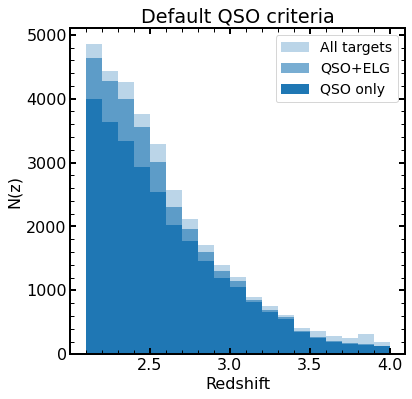

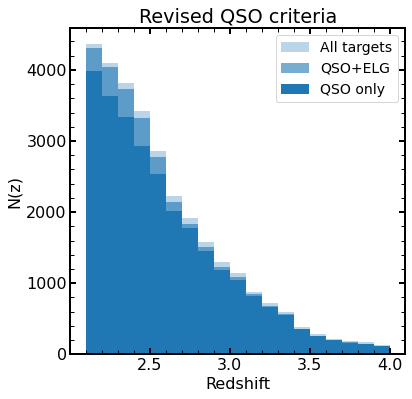

In [88]:
# distribution of redshifts per target type and per QSO selection method

rr = [qso_cut, qso_cut&(is_qso|is_elg), qso_cut&is_qso]
rnames = ['All targets', 'QSO+ELG', 'QSO only']

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
#bins = np.arange(0, 4, 0.2)  #default range from 0 to 4
bins = np.arange(2.1, 4.1, 0.1)  #high z range 2.1 to 4.1

alphas = [0.3, 0.6, 1.0]

for i in range(3):
    rq = rr[i]
    ax.hist(cat['Z'][(rq)], color = f'C{0}', bins = bins, label = f'{rnames[i]}',alpha=alphas[i])
    ax.legend(fontsize = 14)
    ax.set_ylabel("N(z)")
    ax.set_xlabel("Redshift")
    ax.set_title("Default QSO criteria")

## revised    
rr = [qso_cuts, qso_cuts&(is_qso|is_elg), qso_cuts&is_qso]
rnames = ['All targets', 'QSO+ELG', 'QSO only']

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
#bins = np.arange(0, 4, 0.2)  #default range from 0 to 4
bins = np.arange(2.1, 4.1, 0.1)  #high z range 2.1 to 4.1

alphas = [0.3, 0.6, 1.0]

for i in range(3):
    rq = rr[i]
    ax.hist(cat['Z'][(rq)], color = f'C{0}', bins = bins, label = f'{rnames[i]}',alpha=alphas[i])
    ax.legend(fontsize = 14)
    ax.set_ylabel("N(z)")
    ax.set_xlabel("Redshift")
    ax.set_title("Revised QSO criteria")



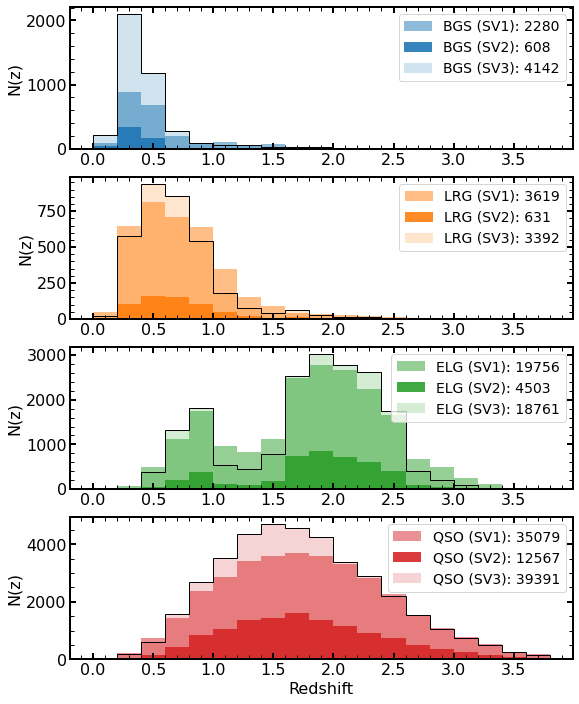

In [89]:
# distribution of redshifts per target type and per Survey

rr = [is_bgs, is_lrg, is_elg, is_qso]
rnames = ['BGS', 'LRG', 'ELG', 'QSO']

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

for i, ax in enumerate(axs.flatten()):
    rq = qso_cuts&rr[i]
    ax.hist(cat['Z'][(rq)&is_sv1], color = f'C{i}', bins = bins, label = f'{rnames[i]} (SV1): {len(cat[rq&is_sv1])}',alpha=0.5)
    ax.hist(cat['Z'][(rq)&is_sv2], color = f'C{i}', bins = bins, label = f'{rnames[i]} (SV2): {len(cat[rq&is_sv2])}',alpha=0.9)
    ax.hist(cat['Z'][(rq)&is_sv3], color = f'C{i}', bins = bins, label = f'{rnames[i]} (SV3): {len(cat[rq&is_sv3])}',alpha=0.2)
    ax.hist(cat['Z'][(rq)&is_sv3], color = 'k', bins = bins, histtype='step', alpha=1)
    ax.legend(fontsize = 14)
    ax.set_ylabel("N(z)")
    if i==3: ax.set_xlabel("Redshift")


## Compare TSNR2_QSO and TSNR2_LRG (In progress)

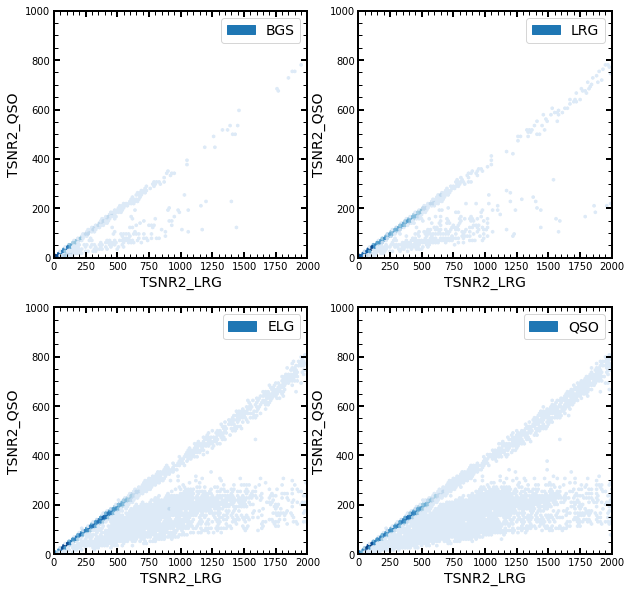

In [103]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10))
#bins = np.arange(0, 4, 0.2)

rr = [is_bgs, is_lrg, is_elg, is_qso]
rnames = ['BGS', 'LRG', 'ELG', 'QSO']

for i, ax in enumerate(axs.flatten()):
    rq = qso_cuts&rr[i]
    ax.hexbin(cat['TSNR2_LRG'][rq], cat['TSNR2_QSO'][rq], bins = 100, norm=LogNorm(vmin=0.5,vmax=1e2), 
              label = f'{rnames[i]}', cmap='Blues', extent=[0,2000,0,1000])
    ax.set_xlim(0,2e3)
    ax.set_ylim(0,1e3)
    ax.legend(fontsize=14)
    ax.set_xlabel('TSNR2_LRG',fontsize=14)
    ax.set_ylabel('TSNR2_QSO',fontsize=14)

